# XGBoost Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

## Load Daily Delhi Climate Train and Test data

In [2]:


train_df = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date']).set_index('date')
test_df  = pd.read_csv('DailyDelhiClimateTest.csv',  parse_dates=['date']).set_index('date')

# Keep only humidity
train_df = train_df[['humidity']].copy()
test_df  = test_df[['humidity']].copy()

## Create X_train, y_train, X_test,y_test data sets

In [3]:

# Create lag features (use last 7 days)

LAGS = 7

def create_lag_features(df, lag=7, col='humidity'):
    df = df.copy()
    for i in range(1, lag + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)
    df = df.dropna()
    return df

# Train lags from train only
train_lag = create_lag_features(train_df, lag=LAGS, col='humidity')

# Test lags need LAGS days of context from the end of train
test_with_ctx = pd.concat([train_df.tail(LAGS), test_df], axis=0)
test_lag_full = create_lag_features(test_with_ctx, lag=LAGS, col='humidity')
# Keep only genuine test rows (drop the context rows)
test_lag = test_lag_full.loc[test_df.index.intersection(test_lag_full.index)].copy()

# Final matrices
X_train = train_lag.drop(columns=['humidity'])
y_train = train_lag['humidity']
X_test  = test_lag.drop(columns=['humidity'])
y_test  = test_lag['humidity']


## Prediction interval, Model Creation, and Fit

In [4]:


# Split-Conformal setup (calibration slice)

ALPHA = 0.05  # 95% PI
cal_size = max(60, int(0.2 * len(train_lag)))  # ~20% of train (>=60)

train_main = train_lag.iloc[:-cal_size].copy()
cal_df     = train_lag.iloc[-cal_size:].copy()

X_main = train_main.drop(columns=['humidity'])
y_main = train_main['humidity']

X_cal  = cal_df.drop(columns=['humidity'])
y_cal  = cal_df['humidity']


# Train on main, get calibration residuals

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_main, y_main)
yhat_cal  = model.predict(X_cal)
resid_cal = (y_cal.values - yhat_cal)

q_low  = np.quantile(resid_cal, ALPHA / 2)        # e.g., 2.5th percentile
q_high = np.quantile(resid_cal, 1 - ALPHA / 2)    # e.g., 97.5th percentile


# Refit on full train, predict test

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Conformal PI on test: shift by calibration residual quantiles
pi_lower = y_pred + q_low
pi_upper = y_pred + q_high


## Plot Actual Test Data, Predicted Test Data, and Precision Interval

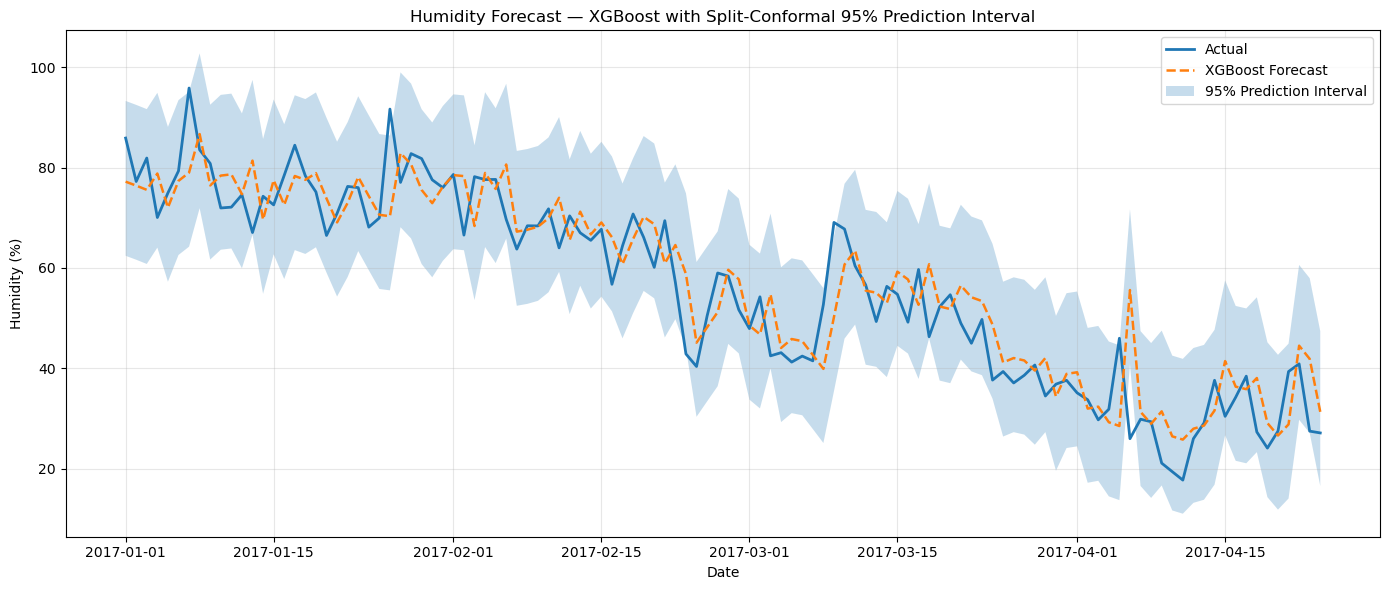

In [5]:

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', linestyle='--', linewidth=1.8)
plt.fill_between(y_test.index, pi_lower, pi_upper, alpha=0.25, label=f'{int((1-ALPHA)*100)}% Prediction Interval')
plt.title('Humidity Forecast — XGBoost with Split-Conformal 95% Prediction Interval')
plt.xlabel('Date');
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("XgboostForecastPLOT.png")
plt.show()

## Compute Errors and Coverage of Precision Interval

In [10]:
mse  = mean_squared_error(y_test.values, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test.values, y_pred)
coverage = np.mean((y_test.values >= pi_lower) & (y_test.values <= pi_upper))

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"{int((1-ALPHA)*100)}% PI coverage: {coverage:.2%}")


MSE:  57.4694
RMSE: 7.5809
MAE:  5.6970
95% PI coverage: 94.74%


## Interpretability Plots

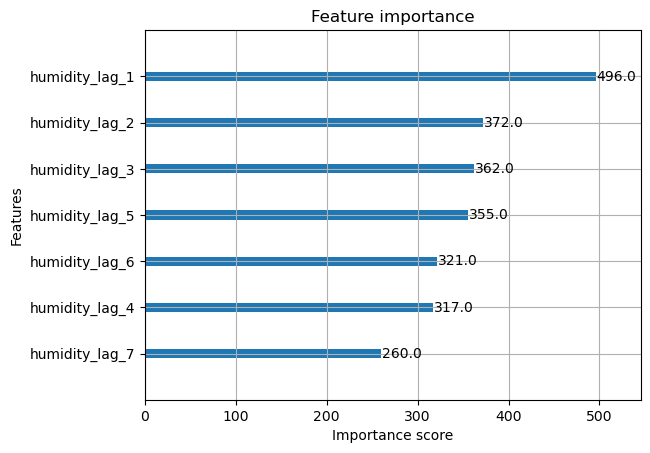

{'humidity_lag_1': 3431.917724609375, 'humidity_lag_2': 100.19515228271484, 'humidity_lag_3': 130.51077270507812, 'humidity_lag_4': 118.07515716552734, 'humidity_lag_5': 155.8759307861328, 'humidity_lag_6': 152.50379943847656, 'humidity_lag_7': 139.58169555664062}


In [15]:
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model, importance_type="weight")   # or "gain", "cover"
plt.savefig("XgboostFeatureImportancePLOT.png")
plt.show()

# Get raw importance scores
importance = model.get_booster().get_score(importance_type="gain")
print(importance)

In [21]:
import shap
shap.initjs()
# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot (global view of feature influence)
#shap.summary_plot(shap_values, X_test)

# Force plot (local explanation for one prediction)
#shap.plots.force(shap_values[0])
shap.summary_plot(shap_values, X_test, show=False)  # stop auto-display
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()